# Main functions used in experiments

In [4]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment: Windy gridworld
Gives a reward of -1 for each step taken, while the final state is not reached

In [5]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()
env??

## Policy

### Target policy (choose greedy vs non-greedy)
Greedy policy 

In [6]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a greedy policy
        """   
        # for state and action only:
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        if action in max_indices:
            prob = 1/len(max_indices)
        else:
            prob = 0
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """

        best_actions = [i for i, j in enumerate([self.Q[obs][i] for i in range(4)]) 
                   if j == max([self.Q[obs][i] for i in range(4)])] 

        best_action = np.random.choice(best_actions)
        
        return best_action

In [7]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a epsilon greedy policy
        """

        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        # all probs are equal, give all equal probabilities
        if len(max_indices) == len(action_probs):
            return 1/len(max_indices)
            
        if action in max_indices:
            prob = (1-self.epsilon)/len(max_indices)
        else:
            prob = epsilon / (len(action_probs) - len(max_indices))
        
        return prob
    

    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
         
        best_actions = [i for i, j in enumerate(self.Q[obs])
                   if j == np.max(self.Q[obs])] 

        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice(best_actions)
        else:
            # return a random action
            action = np.random.randint(0,4)
                
        return action


## Monte Carlo

## Sampling function given an env and policy
Function to sample an episode from the env.

In [8]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        

    return states, actions, rewards, dones

In [9]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.nS, env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(1):
    trajectory_data = sample_episode(env, bp)
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 3311


## MC Importance Sampling


In [57]:
def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05, seed=42):
    """
    Monte Carlo prediction algorithm. Calculates the Q function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        weighted: Boolean flag to use weighted or ordinary importance sampling.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from (state, action) -> value.
    """

    # set the current Q to a large negative value
    Q = np.ones((env.nS, env.nA)) * -100
    if weighted:
        C = np.zeros((env.nS, env.nA))
    else:
        returns_count = defaultdict(lambda: defaultdict(float))
    
    episode_lens = []
    
    # set seed
    np.random.seed(seed)
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral and target policy
        behavior_policy.Q = Q
        target_policy.Q = Q        
    
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states)) 

        G = 0        
        W = 1
        
        # loop backwards over the trajectory
        for i, timestep in enumerate(range(len(states)-1, -1, -1)):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            if weighted:
                # add W to the sum of weights C
                C[s][a] += W
                Q[s][a] += W/C[s][a] * (G - Q[s][a])
            else:
                returns_count[s][a] += 1 
                # use every visit incremental method
                Q[s][a] += 1/returns_count[s][a] * (W * G - Q[s][a])
            
            W *= (target_policy.get_probs(s, a)) / (behavior_policy.get_probs(s, a))        

            if W == 0:
                break
        
    return Q, episode_lens

## Performance
Plot the episode length over training

In [59]:
# Reproducible
seed = 10

# set other parameters
epsilon = 0.1
gamma = 1.0
num_episodes = 1000
Q = np.ones((env.nS, env.nA)) * -100
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths = mc_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)
print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths = mc_importance_sampling(env, 
                                                               behavioral_policy, target_policy,
                                                               num_episodes, weighted=True, discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)



  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (1000 episodes)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (1000 episodes)


100%|██████████| 1000/1000 [00:02<00:00, 345.19it/s]


In [60]:
# check how long an episode takes under the found Q function
greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
greedy_weighted = GreedyPolicy(Q_mc_weighted)

ordinary_episode = sample_episode(env, greedy_ordinary)
weighted_episode = sample_episode(env, greedy_weighted)

print(f"resulting episode length ordinary: {len(ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(weighted_episode[0])}")

resulting episode length ordinary: 16
resulting episode length weighted: 17


### Plotting episode lengths during training

In [61]:
print(mc_ordinary_epslengths)

print(mc_weighted_epslengths)

[6870, 1863, 128, 93, 28, 78, 20, 84, 60, 28, 23, 23, 20, 27, 24, 31, 27, 35, 20, 23, 18, 30, 28, 30, 22, 24, 126, 20, 39, 21, 25, 33, 22, 24, 41, 22, 19, 32, 19, 19, 27, 20, 98, 25, 23, 41, 29, 41, 58, 24, 91, 21, 26, 47, 50, 51, 19, 28, 38, 18, 27, 27, 46, 21, 24, 37, 19, 17, 17, 20, 20, 24, 18, 17, 17, 19, 23, 17, 19, 18, 18, 17, 20, 20, 17, 20, 20, 25, 18, 17, 17, 23, 17, 18, 19, 18, 18, 30, 19, 25, 17, 18, 19, 18, 27, 21, 27, 25, 18, 20, 19, 29, 18, 17, 17, 20, 18, 17, 18, 17, 18, 19, 17, 19, 20, 21, 18, 17, 21, 17, 17, 19, 17, 16, 17, 18, 17, 21, 18, 18, 18, 17, 22, 34, 24, 16, 18, 16, 18, 16, 18, 21, 18, 17, 19, 17, 16, 23, 18, 16, 17, 19, 19, 18, 19, 16, 16, 16, 22, 21, 21, 21, 17, 22, 17, 16, 20, 18, 22, 16, 21, 16, 28, 19, 16, 19, 16, 17, 19, 16, 16, 22, 19, 17, 16, 17, 20, 19, 17, 20, 20, 21, 16, 18, 16, 23, 18, 20, 16, 17, 18, 17, 16, 16, 16, 16, 21, 17, 19, 16, 16, 16, 22, 16, 21, 16, 19, 16, 16, 19, 20, 16, 16, 20, 19, 29, 20, 22, 18, 16, 16, 16, 16, 16, 17, 20, 16, 17, 1

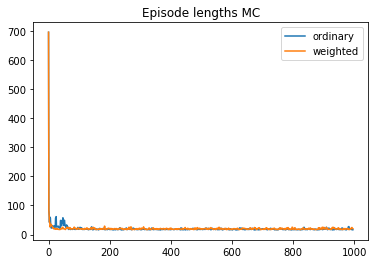

In [62]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 3

plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths MC')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

## Temporal Difference

### TO-DO: TD Ordinary Importance Sampling (make it work for gridworld)
Copied from TD_lab. Currently on-policy, needs to be off-policy.

Confused: do we need value functions instead of q-values? Do we even use importance weights in off-policy TD? Are there more off-policy TD methods besides SARSA?

In [ ]:
def sarsa(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # initial state is 3,0 in the grid (according to source code)
        s = env.reset()
        a = policy.sample_action(s)
        final_state_reached = False
        
        while True:
            # new actions
            s_prime, r, final_state, _ = env.step(a)
            
            # keep track of stats
            R += r
            i += 1    
            
            # sample action at state s_prime
            a_prime = policy.sample_action(s_prime)

            # update Q 
            Q[s][a] += alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])    
    
            # update policy
            policy.Q = Q
            
            # if final state, terminate loop
            if final_state:
                break
        
            # update current s and a for next iteration
            s = s_prime
            a = a_prime
            
        stats.append((i, R))
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

### TO-DO: TD Weighted Importance Sampling (same as above but weighted)

In [ ]:
## TD weighted importance sampling

## Experiments